# Predicting Upcoming Netflix Titles with Logistic Regression

 Netflix contains over 12,000 unique titles comprising of Movies and TV Shows. Since Netflix is subscription based, and has desire to keep it's subscribers and create new ones, they often change the titles that are avaible on the platform on a monthly basis, removing some and adding new ones.. I wanted to see if I could accurately predict Netflix titles for the upcoming month with machine learning algorithms. By web scraping information from IMDb's website, I hope to observe factors that could influence their decision.

### I utilized the Scrapy library to perform my web scraping. The following code generates a spider which will extract the data. I also added a "user agent" to spoof the header, which will allow me to make to make multiple requests to the website to prevent being blocked.

### *** I ran this code in Visual Studio Code because of it's integrated terminal ***

In [1]:
import scrapy
from scrapy.linkextractors import LinkExtractor
from scrapy.spiders import CrawlSpider, Rule


class ImdbDataSpider(CrawlSpider):
    name = 'imdb_data'
    allowed_domains = ['imdb.com']
    

    user_agent = 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/87.0.4280.88 Safari/537.36'

    def start_requests(self):
        yield scrapy.Request(url='https://www.imdb.com/search/title/?title_type=feature&count=100&view=simple', headers={
            'User-Agent': self.user_agent
        })

    rules = (
        Rule(LinkExtractor(restrict_xpaths="//div[@class='lister-item-content']"), callback='parse_item', follow=True, process_request='set_user_agent'),
        Rule(LinkExtractor(restrict_xpaths="(//a[@class='lister-page-next next-page'])[2]"), process_request='set_user_agent')
    )

    def set_user_agent(self, request, spider):
        request.headers['User-Agent'] = self.user_agent
        return request
   

    def parse_item(self, response):
       yield {
           'Title': response.xpath("//div[@class='title_wrapper']/h1/text()[1]").get(),
           'Year': response.xpath("//span[@id='titleYear']/a/text()").get(),
           'Rating': response.xpath("//span[@itemprop='ratingValue']/text()").get(),
           'Amount_of_User_Rating': response.xpath("//div[@class='imdbRating']/a/span/text()").get(),
           'Maturity_Rating': response.xpath("//div[@class='subtext']/node()[1]").get().strip(),
           'Genre': response.xpath("//div[@class='subtext']/a[1]/text()").get(),
           'Duration': response.xpath("(//time)[2]/text()").get(),
           'user-agent': response.request.headers['User-Agent']
       }

### The following packages are what I'll use to perform my data manipulation and analysis 

In [1]:
import pandas as pd # where I'll be managing my dataframe 
import numpy as np
import matplotlib.pyplot as plt #Data Visualization 
import seaborn as sns # Further Data Visulaization 
%matplotlib inline 

In [2]:
train = pd.read_csv("/Users/Judley Joseph/ds_projects/imdb/movie_dataset.csv")

In [3]:
train.head()

,Title,Year,Rating,Amount_of_User_Rating,Maturity_Rating,Genre,Duration,user-agent
0,Tenet,2020.0,7.6,"216,198",PG-13,Action,150 min,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...
1,365 Days,2020.0,3.3,"46,017",TV-MA,Drama,114 min,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...
2,Dune,2021.0,NaN,NaN,PG-13,Adventure,NaN,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...
3,Mission: Impossible 7,2021.0,NaN,NaN,NaN,Action,NaN,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...
4,Outside the Wire,2021.0,NaN,NaN,R,Action,114 min,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...


## At first glance, there are some null values. I'll use a heatmap to point them out.

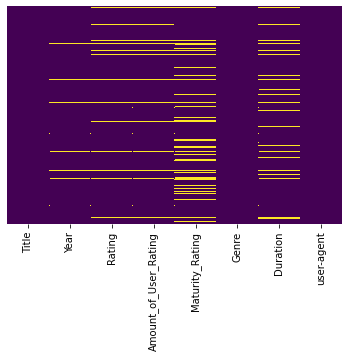

In [3]:
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

## Upon first glance of my scraped data, there are null values for ratings, quantity of user ratings, and duration. 

Upon further inspection, this stems from the fact that some movies will be released in 2021, so I'll remove them 

In [3]:
train.dropna(inplace=True)

In [6]:
train

,Title,Year,Rating,Amount_of_User_Rating,Maturity_Rating,Genre,Duration,user-agent
0,Tenet,2020.0,7.6,"216,198",PG-13,Action,150 min,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...
1,365 Days,2020.0,3.3,"46,017",TV-MA,Drama,114 min,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...
5,Wolfwalkers,2020.0,8.2,"4,068",PG,Animation,103 min,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...
6,Breach,2020.0,2.7,"1,149",R,Action,92 min,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...
7,The Gentlemen,2019.0,7.8,"217,247",R,Action,113 min,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...
...,...,...,...,...,...,...,...,...
6058,The Answer Man,2009.0,6.4,"6,246",R,Comedy,97 min,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...
6059,Deadline,1980.0,5.5,434,R,Drama,90 min,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...
6060,F,2010.0,4.6,"3,802",R,Crime,79 min,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...
6062,The Second Jungle Book: Mowgli & Baloo,1997.0,4.5,966,PG,Adventure,88 min,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4600 entries, 0 to 6063
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Title                  4600 non-null   object 
 1   Year                   4600 non-null   float64
 2   Rating                 4600 non-null   float64
 3   Amount_of_User_Rating  4600 non-null   object 
 4   Maturity_Rating        4600 non-null   object 
 5   Genre                  4600 non-null   object 
 6   Duration               4600 non-null   object 
 7   user-agent             4600 non-null   object 
dtypes: float64(2), object(6)
memory usage: 323.4+ KB


## Now my DataFrame looks much better. I've also noticed an unecessary " .0 " at then end of Year Column, so I'll remove it 

In [4]:
train['Year'] = train['Year'].astype(np.int64).replace('\.0', '', regex=True)

In [9]:
train.head()

,Title,Year,Rating,Amount_of_User_Rating,Maturity_Rating,Genre,Duration,user-agent
0,Tenet,2020,7.6,"216,198",PG-13,Action,150 min,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...
1,365 Days,2020,3.3,"46,017",TV-MA,Drama,114 min,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...
5,Wolfwalkers,2020,8.2,"4,068",PG,Animation,103 min,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...
6,Breach,2020,2.7,"1,149",R,Action,92 min,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...
7,The Gentlemen,2019,7.8,"217,247",R,Action,113 min,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...


### I don't need the user-agent column. This was only created to allow myself to send many request to the imdb website

In [5]:
train.drop('user-agent', axis=1, inplace=True)

In [11]:
train.head()

,Title,Year,Rating,Amount_of_User_Rating,Maturity_Rating,Genre,Duration
0,Tenet,2020,7.6,"216,198",PG-13,Action,150 min
1,365 Days,2020,3.3,"46,017",TV-MA,Drama,114 min
5,Wolfwalkers,2020,8.2,"4,068",PG,Animation,103 min
6,Breach,2020,2.7,"1,149",R,Action,92 min
7,The Gentlemen,2019,7.8,"217,247",R,Action,113 min


In [12]:
train['Maturity_Rating'].unique()

array(['PG-13', 'TV-MA', 'PG', 'R', 'Not Rated', 'G', 'TV-PG', 'Passed',
       'Unrated', 'Approved', 'M', 'TV-14', 'GP', 'NC-17', 'TV-G', 'M/PG',
       'TV-Y7', 'X', 'TV-13'], dtype=object)

In [7]:
#dropping all uncessary rows with wierd ratings 

train[((train.Maturity_Rating != 'Approved') &( train.Maturity_Rating != 'Unrated') & (train.Maturity_Rating != 'Passed'))]
train[((train.Maturity_Rating != 'NC-17') &( train.Maturity_Rating != 'GP') & (train.Maturity_Rating != 'M/PG'))]
train[((train.Maturity_Rating != 'X') &( train.Maturity_Rating != 'TV-13') & (train.Maturity_Rating != 'TV-G'))]
train[(train.Maturity_Rating != 'TV-Y7')]

,Title,Year,Rating,Amount_of_User_Rating,Maturity_Rating,Genre,Duration
0,Tenet,2020,7.6,"216,198",PG-13,Action,150 min
1,365 Days,2020,3.3,"46,017",TV-MA,Drama,114 min
5,Wolfwalkers,2020,8.2,"4,068",PG,Animation,103 min
6,Breach,2020,2.7,"1,149",R,Action,92 min
7,The Gentlemen,2019,7.8,"217,247",R,Action,113 min
...,...,...,...,...,...,...,...
6058,The Answer Man,2009,6.4,"6,246",R,Comedy,97 min
6059,Deadline,1980,5.5,434,R,Drama,90 min
6060,F,2010,4.6,"3,802",R,Crime,79 min
6062,The Second Jungle Book: Mowgli & Baloo,1997,4.5,966,PG,Adventure,88 min


In [14]:
train['Maturity_Rating']

0           PG-13
1           TV-MA
5              PG
6               R
7               R
          ...    
6058            R
6059            R
6060            R
6062           PG
6063    Not Rated
Name: Maturity_Rating, Length: 4600, dtype: object

## I also loaded tv shows from imdb website. Since the html was similar and i used the same scraping methods on it, I'll still run many of the same commands I did on the previous dataset

In [8]:
tele = pd.read_csv("/Users/Judley Joseph/ds_projects/imdb/tv_dataset.csv")
# Drop the null values 
tele.dropna(inplace=True)

# Drop the user - agent column 
tele.drop('user-agent', axis=1, inplace=True)


# Change the duration to a value the machine algo can learn from 
tele['Duration'] = tele['Duration'].str.replace('min','*1').apply(eval)

In [8]:
tele.head()

,Title,Year,Rating,Amount_of_User_Rating,Maturity_Rating,Genre,Duration
0,Tin Star,TV Series (2017–2020)\n,7.3,"11,411",TV-MA,Crime,60
1,Dexter,TV Series (2006–2021)\n,8.6,"640,203",TV-MA,Crime,53
2,The Witcher,TV Series (2019– )\n,8.2,"287,145",TV-MA,Action,60
3,The Sopranos,TV Series (1999–2007)\n,9.2,"295,463",TV-MA,Crime,55
4,The Mandalorian,TV Series (2019– )\n,8.7,"246,519",TV-14,Action,40


## the year column needs to be formmated to look like the Movie dataset 

In [17]:
tele['Maturity_Rating'].unique()

array(['TV-MA', 'TV-14', 'TV-PG', 'TV-Y7-FV', 'TV-G', 'Not Rated',
       'TV-Y7', 'TV-Y', 'PG', 'Approved', 'G', 'R', 'Unrated', 'PG-13'],
      dtype=object)

In [9]:
tele[((tele.Maturity_Rating != 'Approved') &( tele.Maturity_Rating != 'Unrated') & (tele.Maturity_Rating != 'Passed'))]
tele[((tele.Maturity_Rating != 'TV-Y') &( tele.Maturity_Rating != 'TV-Y7-FV') & (tele.Maturity_Rating != 'PG'))]
tele[((tele.Maturity_Rating != 'R') &( train.Maturity_Rating != 'G') & (train.Maturity_Rating != 'PG-13'))]
tele[(tele.Maturity_Rating != 'Not Rated')]


<ipython-input-9-d12f748da9d3>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tele[((tele.Maturity_Rating != 'R') &( train.Maturity_Rating != 'G') & (train.Maturity_Rating != 'PG-13'))]


,Title,Year,Rating,Amount_of_User_Rating,Maturity_Rating,Genre,Duration
0,Tin Star,TV Series (2017–2020)\n,7.3,"11,411",TV-MA,Crime,60
1,Dexter,TV Series (2006–2021)\n,8.6,"640,203",TV-MA,Crime,53
2,The Witcher,TV Series (2019– )\n,8.2,"287,145",TV-MA,Action,60
3,The Sopranos,TV Series (1999–2007)\n,9.2,"295,463",TV-MA,Crime,55
4,The Mandalorian,TV Series (2019– )\n,8.7,"246,519",TV-14,Action,40
...,...,...,...,...,...,...,...
3876,Wicked Tuna: North vs. South,TV Series (2014– )\n,6.5,92,TV-14,Reality-TV,47
3880,Can't Pay? We'll Take It Away!,TV Series (2014–2018)\n,7.2,556,TV-MA,Documentary,60
3885,Bert the Conqueror,TV Series (2010– )\n,7.8,123,TV-G,Reality-TV,30
3889,The Chris Gethard Show,TV Series (2015– )\n,6.8,339,TV-MA,Comedy,60


In [18]:
tele['Year']

0       TV Series (2017–2020)\n
1       TV Series (2006–2021)\n
2          TV Series (2019– )\n
3       TV Series (1999–2007)\n
4          TV Series (2019– )\n
                 ...           
3884       TV Series (1977– )\n
3885       TV Series (2010– )\n
3889       TV Series (2015– )\n
3892    TV Series (1997–2005)\n
3912    TV Series (2017–2018)\n
Name: Year, Length: 1445, dtype: object

In [10]:
# Now to adjust the Year 

tele['Year'] = tele['Year'].str.replace('TV Series', '')
tele['Year'] = tele['Year'].str.replace('(', '')
tele['Year'] = tele['Year'].str.replace(')', '')
tele['Year'] = tele['Year'].str.replace('\n', '')


In [20]:
tele['Year']

0        2017–2020
1        2006–2021
2           2019– 
3        1999–2007
4           2019– 
           ...    
3884        1977– 
3885        2010– 
3889        2015– 
3892     1997–2005
3912     2017–2018
Name: Year, Length: 1445, dtype: object

In [11]:
tele['Year'] = tele['Year'].astype(str).str[:5]

In [12]:
tele['Year']

0        2017
1        2006
2        2019
3        1999
4        2019
        ...  
3884     1977
3885     2010
3889     2015
3892     1997
3912     2017
Name: Year, Length: 1445, dtype: object

## Finally, my dataframe is exactly how I want it. Now to run some analysis


### We'll start with visualizing the "Year" Column to see if we can find anything interesting

In [12]:
import cufflinks as cf 

In [13]:
cf.go_offline()

In [18]:
train['Year'].iplot(kind='hist',bins=30)

### By generating a Histogram for the Genre column, we can gain insight into it's  popularity can give us insight into what appears on Netflix.  

In [19]:
train['Genre'].iplot(kind='hist',bins=30)

## We'll also add something for Maturity Rating 

In [21]:
train['Maturity_Rating'].iplot(kind='hist',bins=30)

In [27]:
train.head()

,Title,Year,Rating,Amount_of_User_Rating,Maturity_Rating,Genre,Duration
0,Tenet,2020,7.6,"216,198",PG-13,Action,150 min
1,365 Days,2020,3.3,"46,017",TV-MA,Drama,114 min
5,Wolfwalkers,2020,8.2,"4,068",PG,Animation,103 min
6,Breach,2020,2.7,"1,149",R,Action,92 min
7,The Gentlemen,2019,7.8,"217,247",R,Action,113 min


### Next, we'll check the distribution of movie/tv show rating, as this can be a big factor influencing Netflix's selections

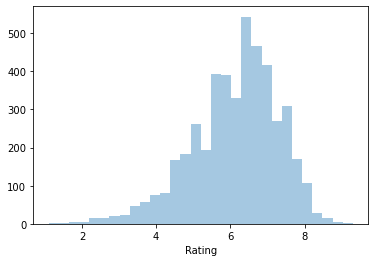

In [28]:
sns.distplot(train['Rating'].dropna(),kde=False,bins=30)

# Label Encoding Section 

In [12]:
import category_encoders as ce

### Maturity Rating Encoding 

In [30]:
train['Maturity_Rating'].unique()

array(['PG-13', 'TV-MA', 'PG', 'R', 'Not Rated', 'G', 'TV-PG', 'Passed',
       'Unrated', 'Approved', 'M', 'TV-14', 'GP', 'NC-17', 'TV-G', 'M/PG',
       'TV-Y7', 'X', 'TV-13'], dtype=object)

In [32]:
tele['Maturity_Rating'].unique()

array(['TV-MA', 'TV-14', 'TV-PG', 'TV-Y7-FV', 'TV-G', 'Not Rated',
       'TV-Y7', 'TV-Y', 'PG', 'Approved', 'G', 'R', 'Unrated', 'PG-13'],
      dtype=object)

In [13]:
#Movie Dataset
maturity_col = ['Maturity_Rating']
encoder = ce.OrdinalEncoder(cols=maturity_col)
train = encoder.fit_transform(train)

#Tv dataset
maturity_col2 = ['Maturity_Rating']
encoder = ce.OrdinalEncoder(cols=maturity_col2)
tele = encoder.fit_transform(tele)


### Genre Encoding

In [24]:
train['Genre'].unique()

array(['Action', 'Drama', 'Animation', 'Biography', 'Comedy', 'Adventure',
       'Crime', 'Horror', 'Mystery', 'Musical', 'Western', 'Fantasy',
       'Family', 'Romance', 'Thriller', 'Sci-Fi', 'Film-Noir', 'War',
       'Music', 'History'], dtype=object)

In [27]:
tele['Genre'].unique()

array(['Crime', 'Action', 'Drama', 'Comedy', 'Animation', 'Adventure',
       'Reality-TV', 'Biography', 'Horror', 'Western', 'Documentary',
       'Game-Show', 'Short', 'Romance', 'Thriller', 'Fantasy', 'Family',
       'Mystery', 'Talk-Show', 'Music', 'News', 'Sci-Fi', 'History'],
      dtype=object)

In [14]:
#Movie Dataset
genre_col = ['Genre']
encoder = ce.OrdinalEncoder(cols=genre_col)
train = encoder.fit_transform(train)

#TV Dataset
genre_col2 = ['Genre']
encoder = ce.OrdinalEncoder(cols=genre_col2)
tele = encoder.fit_transform(tele)


In [15]:
#Change Duration so the machine learning algo can gain useful insights from it 
train['Duration'] = train['Duration'].str.replace('min','*1').apply(eval)

## Limiting the amount of rows in each Dataframe

In [20]:
tele.shape

(1445, 7)

In [16]:
tv_dataset = tele.head(1000)

In [17]:
tv_dataset.shape

(1000, 7)

In [27]:
train.shape

(4600, 7)

In [17]:
movie_dataset = train.head(1000)

In [19]:
movie_dataset.shape

(1000, 7)

In [18]:
frames = [movie_dataset, tv_dataset]
complete_set = pd.concat(frames)

In [21]:
complete_set

,Title,Year,Rating,Amount_of_User_Rating,Maturity_Rating,Genre,Duration
0,Tenet,2020,7.6,"216,198",1,1,150
1,365 Days,2020,3.3,"46,017",2,2,114
5,Wolfwalkers,2020,8.2,"4,068",3,3,103
6,Breach,2020,2.7,"1,149",4,1,92
7,The Gentlemen,2019,7.8,"217,247",4,1,113
...,...,...,...,...,...,...,...
1674,Kevin (Probably) Saves the World,2017,7.8,"4,175",2,4,42
1675,Astra Lost in Space,2019,8.1,701,2,5,24
1677,Content Cop,2015,8.9,"11,882",1,11,20
1682,Bravest Warriors,2012,8.2,"3,096",3,5,5


In [19]:
# To shuffle my set...
from sklearn.utils import shuffle
complete_set = shuffle(complete_set)

In [20]:
complete_set

,Title,Year,Rating,Amount_of_User_Rating,Maturity_Rating,Genre,Duration
615,Another World,1964,6.8,816,2,3,60
639,Containment,2016,7.2,"10,015",2,3,60
793,"Eerie, Indiana",1991,8.2,"5,068",7,6,30
76,Locke & Key,2020,7.4,"38,986",2,3,48
120,Pirates of the Caribbean: Dead Men Tell No Tales,2017,6.5,"260,598",1,1,129
...,...,...,...,...,...,...,...
963,My Life as a Teenage Robot,2003,6.9,"8,668",8,5,23
1000,Heartbeat,2016,6.8,"2,848",2,4,60
518,Chance,2016,7.7,"8,934",1,3,60
428,The Holiday Movies that Made Us,2020,7.2,472,3,11,44


In [21]:
final_set = complete_set.head(1246)

In [22]:
final_set

,Title,Year,Rating,Amount_of_User_Rating,Maturity_Rating,Genre,Duration
615,Another World,1964,6.8,816,2,3,60
639,Containment,2016,7.2,"10,015",2,3,60
793,"Eerie, Indiana",1991,8.2,"5,068",7,6,30
76,Locke & Key,2020,7.4,"38,986",2,3,48
120,Pirates of the Caribbean: Dead Men Tell No Tales,2017,6.5,"260,598",1,1,129
...,...,...,...,...,...,...,...
321,Nativity 2: Danger in the Manger!,2012,5.3,"3,083",7,5,105
99,The Imitation Game,2014,8.0,"679,191",1,4,114
370,Vinyl,2016,7.8,"21,508",1,3,60
529,Footloose,2011,5.9,"46,184",1,5,113


In [ ]:
import scrapy
from scrapy.linkextractors import LinkExtractor
from scrapy.spiders import CrawlSpider, Rule


class NetflixLastSpider(CrawlSpider):
    name = 'netflix_last'
    allowed_domains = ['reelgood.com']
    
    user_agent = 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/87.0.4280.88 Safari/537.36'

    def start_requests(self):
        yield scrapy.Request(url='https://reelgood.com/source/netflix?offset=1200', headers={
            'User-Agent': self.user_agent
        })
    

    rules = (
        Rule(LinkExtractor(restrict_xpaths="//tr[@itemprop='itemListElement']"), callback='parse_item', follow=True, process_request='set_user_agent'),
        Rule(LinkExtractor(restrict_xpaths="(//a[@class='css-ytumd6']/@href)[1]"), process_request='set_user_agent')
    )

    def set_user_agent(self, request, spider):
        request.headers['User-Agent'] = self.user_agent
        return request

    def parse_item(self, response):
        yield {
            'Netflix_Title': response.xpath("//h1[@itemprop='name' or class='css-of585f e14injhv7']/text()").get()
        }


In [23]:
# Import current netflix titles

scraped_titles = pd.read_csv("/Users/Judley Joseph/Desktop/Scraped_Netflix_Titles/scraped_titles.csv")

In [56]:
scraped_titles.head()

,Netflix_Title
0,Silver Linings Playbook
1,Breaking Bad
2,The Last Dance
3,The Irishman
4,Platoon


In [28]:
scraped_titles.shape

(1250, 1)

In [24]:
scraped_titles = scraped_titles.drop_duplicates()

In [25]:
scraped_titles.shape

(1246, 1)

In [55]:
final_set.shape

(1246, 7)

In [26]:
final_set = final_set.assign(Netflix_Title=scraped_titles['Netflix_Title'])

In [36]:
final_set.head()

,Title,Year,Rating,Amount_of_User_Rating,Maturity_Rating,Genre,Duration,Netflix_Title
615,Another World,1964,6.8,816,2,3,60,LA Originals
639,Containment,2016,7.2,"10,015",2,3,60,When We First Met
793,"Eerie, Indiana",1991,8.2,"5,068",7,6,30,Middle Men
76,Locke & Key,2020,7.4,"38,986",2,3,48,The Magicians
120,Pirates of the Caribbean: Dead Men Tell No Tales,2017,6.5,"260,598",1,1,129,The Ritual


In [45]:
final_set.shape

(1246, 8)

In [46]:
final_set['Dependent_Variable'] = np.random.randint(2, size=1246)

In [48]:
final_set.head()

,Title,Year,Rating,Amount_of_User_Rating,Maturity_Rating,Genre,Duration,Netflix_Title,Dependent_Variable
615,Another World,1964,6.8,816,2,3,60,LA Originals,1
639,Containment,2016,7.2,"10,015",2,3,60,When We First Met,1
793,"Eerie, Indiana",1991,8.2,"5,068",7,6,30,Middle Men,1
76,Locke & Key,2020,7.4,"38,986",2,3,48,The Magicians,0
120,Pirates of the Caribbean: Dead Men Tell No Tales,2017,6.5,"260,598",1,1,129,The Ritual,0


In [88]:
#this converts categorical variables into dummy/indicator variables


apperance = pd.get_dummies(final_set['Dependent_Variable'],drop_first=True)
# perfect predictors, causes mutlicollinearity 
# we use dropfirst = true to prevent this 

final_set = pd.concat([final_set,apperance],axis=1)

In [91]:
final_set.head()

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,Year,Rating,Amount_of_User_Rating,Maturity_Rating,Genre,Duration,Dependent_Variable,1
0,1,1,0,0,0,0,0,0,0,0,1964,6.8,816,2,3,60,1,1
1,0,0,1,0,0,0,0,1,0,0,2016,7.2,10015,2,3,60,1,1
2,0,1,0,0,1,0,0,0,0,0,1991,8.2,5068,7,6,30,1,1
3,0,0,0,1,1,0,0,0,0,0,2020,7.4,38986,2,3,48,0,0
4,1,0,0,0,0,1,0,0,0,0,2017,6.5,260598,1,1,129,0,0


# I need to encode the Titles column and Netflix_Title columns

In [90]:

title_cols = ['Title', 'Netflix_Title']
hash_enc = ce.HashingEncoder(cols=title_cols , n_components=10)
final_set = hash_enc.fit_transform(final_set)


final_set = final_set.replace(',','', regex=True)

In [67]:
X = final_set.drop('Dependent_Variable', axis=1)

y = final_set['Dependent_Variable']

In [68]:
from sklearn.model_selection import train_test_split 

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=101)

In [70]:
from sklearn.linear_model import LogisticRegression 

In [71]:
logmodel = LogisticRegression()

In [72]:
logmodel.fit(X_train,y_train)

LogisticRegression()

In [73]:
predictions = logmodel.predict(X_test)

In [74]:
from sklearn.metrics import classification_report

In [75]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       194
           1       0.48      1.00      0.65       180

    accuracy                           0.48       374
   macro avg       0.24      0.50      0.32       374
weighted avg       0.23      0.48      0.31       374



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [92]:
acc_log = round(logmodel.score(X_train, y_train) * 100, 2)
acc_log

50.69